In [1]:
from model import Model
import pennylane as qml
import pennylane.numpy as np

In [2]:
name = 'phong_2_simple_1gate'


def func(n, phi):
	return np.cos(phi) ** n


consts = {'ks': 0.5}
scalars = {'n': {'range': (2, 2), 'type': np.uint32}}
angles = {'phi': {'range': (0, np.pi / 2)}}

In [3]:
model = Model(name)
model.set_function(func)
# model.set_consts(consts)
model.set_scalars(scalars)
model.set_angles(angles)

model.set_sample_size(50)

try:
	model.read_samples('samples/' + model.name + '.bin')
except FileNotFoundError:
	model.generate_samples()
	model.read_samples('samples/' + model.name + '.bin')

model.separate()

(<Figure size 4300x300 with 1 Axes>, <Axes: >)

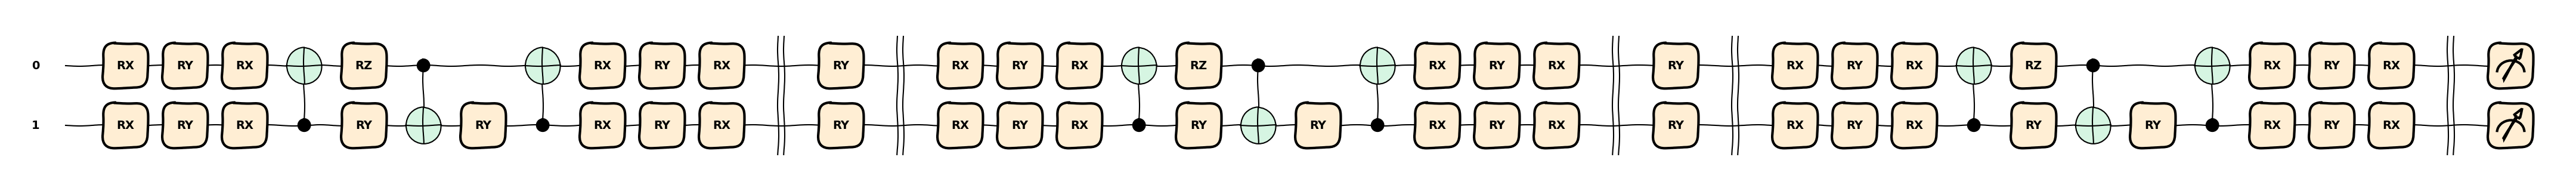

In [4]:
n_qubits = 2
layers = 2

model.push_extra('n_qubits', n_qubits)
model.push_extra('layers', layers)
model.generate_device(n_qubits)


def embedding(data, n_qubits):
	for i in range(n_qubits):
		if i < len(model.scalars):
			value = data[i]
			name = model.header[i + len(model.consts)]
			(min, max) = model.scalars.get(name).get('range')
			if min == max:
				value = value / max * np.pi / 2
			else:
				value = (value - min) / (max - min) * np.pi
			qml.RY(value, wires=i)
		else:
			qml.RY(data[i], wires=i)

	qml.Barrier()

def specialgate(params):
	qml.RX(params[0], wires=0)
	qml.RY(params[1], wires=0)
	qml.RX(params[2], wires=0)
	qml.RX(params[3], wires=1)
	qml.RY(params[4], wires=1)
	qml.RX(params[5], wires=1)

	qml.CNOT(wires=[1,0])

	qml.RZ(params[12],wires=0)
	qml.RY(params[13],wires=1)

	qml.CNOT(wires=[0,1])

	qml.RY(params[14],wires=1)

	qml.CNOT(wires=[1,0])

	qml.RX(params[6], wires=0)
	qml.RY(params[7], wires=0)
	qml.RX(params[8], wires=0)
	qml.RX(params[9], wires=1)
	qml.RY(params[10], wires=1)
	qml.RX(params[11], wires=1)
	qml.Barrier()
model.push_extra('embedding', embedding)
model.push_extra('specialgate', specialgate)

def _circuit(data, params):
	layers = model.extra.get('layers')
	n_qubits = model.extra.get('n_qubits')
	model.extra.get('specialgate')(params)
	for i in range(layers):
		temp_params = params[(4**n_qubits - 1) * i : (4**n_qubits - 1) * (i + 1)]
		model.extra.get('embedding')(data, n_qubits)

		model.extra.get('specialgate')(temp_params)

	return qml.expval(qml.PauliZ(0) @ qml.PauliZ(1))


def _model(circ, input, params):
	return (circ(input, params) + 1) / 2



model.set_model(_model)
model.set_circuit(_circuit)
model.generate_params(((4**n_qubits - 1) * (layers + 1),))

qml.draw_mpl(model.circuit, style='sketch')(model.train_in, model.params)

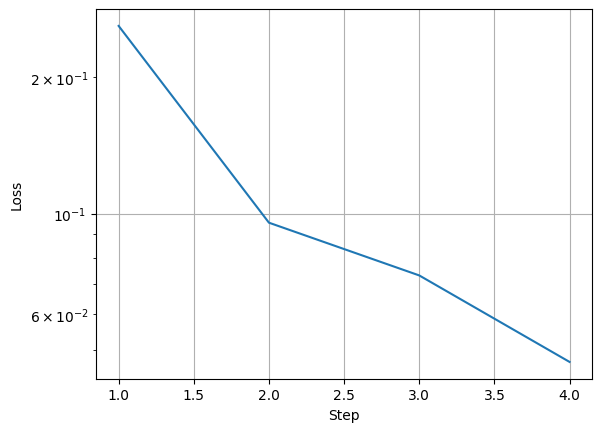

Loss: 0.04704215523611781
Step 4
Estimated time remaining: 00:52:21:788


KeyboardInterrupt: 

In [5]:
model.set_max_steps(500)
model.set_objective(1e-6)
model.optimization(objective=True, callback='graph')

In [12]:
print('Test score:', model.test())

Test score: 1.010409718343665e-06


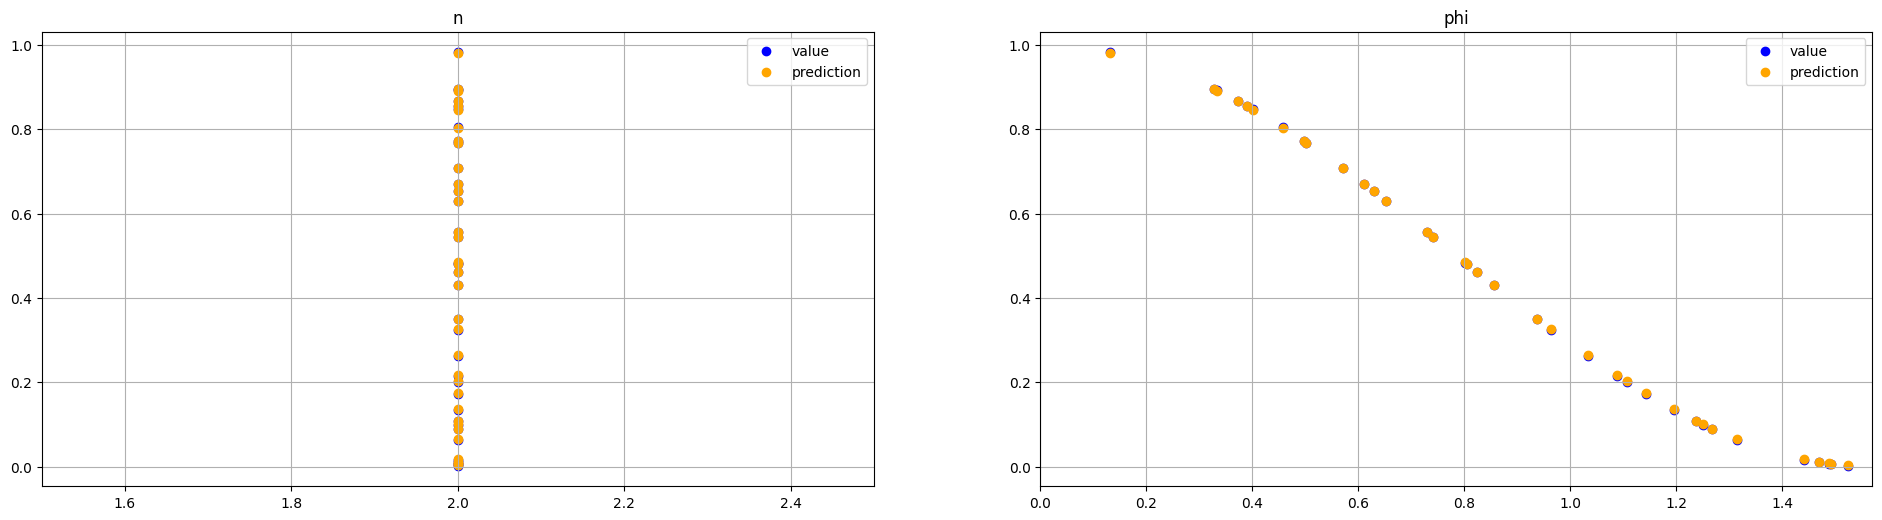

In [13]:
model.draw_train()

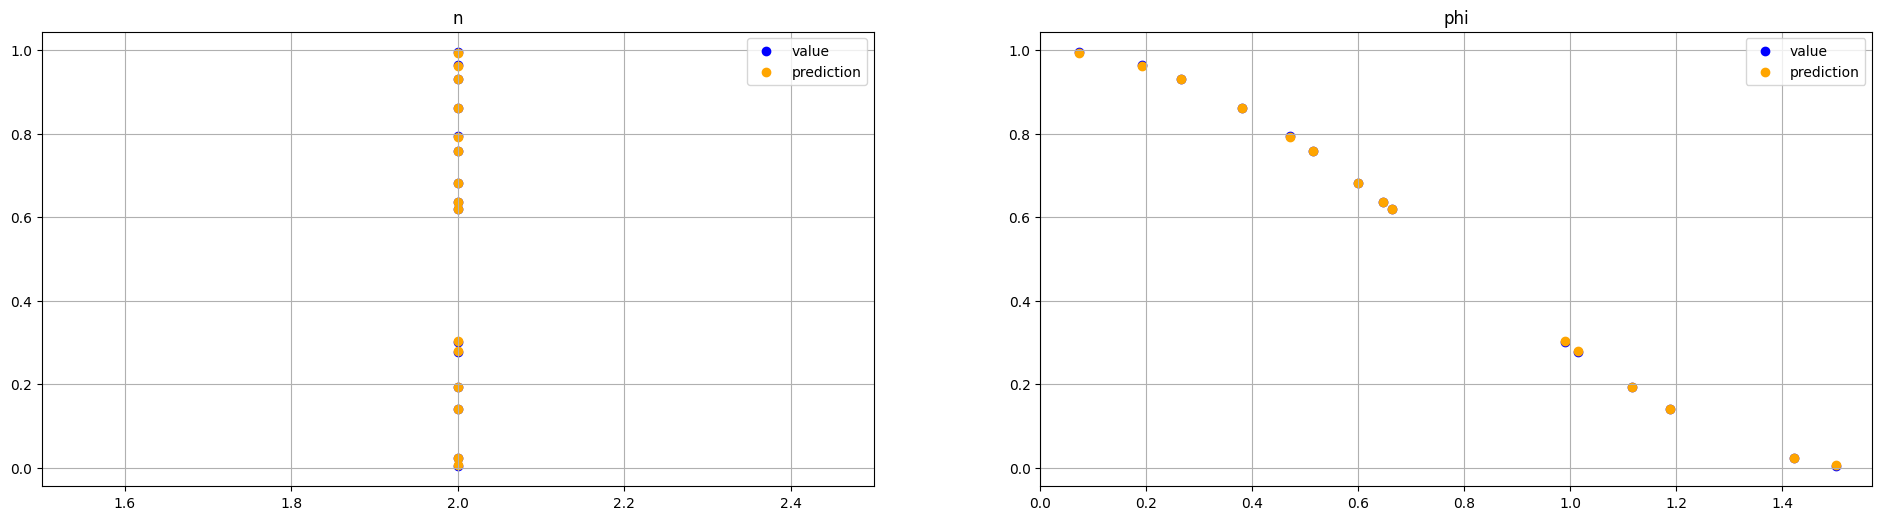

In [14]:
model.draw()

In [10]:
model.serialize('models/' + model.name + '.json')